# LASSO AND RIDGE REGRESSION

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial
import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from statsmodels.iolib.summary2 import summary_col
from sklearn.metrics import log_loss


In [2]:
#IMPORT DATA
data = pd.read_pickle("data.pkl")

In [9]:
# Define Y and X 
y = data["callback"]
covariates = ["female",
    "public_facing",
    "type_1", "type_2", "type_3", "type_4",
    "female_publicOcc",
    "type_1_female", "type_2_female", "type_3_female", "type_4_female",
    "type_1_public", "type_2_public", "type_3_public", "type_4_public",
    "type_1_female_public", "type_2_female_public", "type_3_female_public", "type_4_female_public"
]

X = data[covariates]

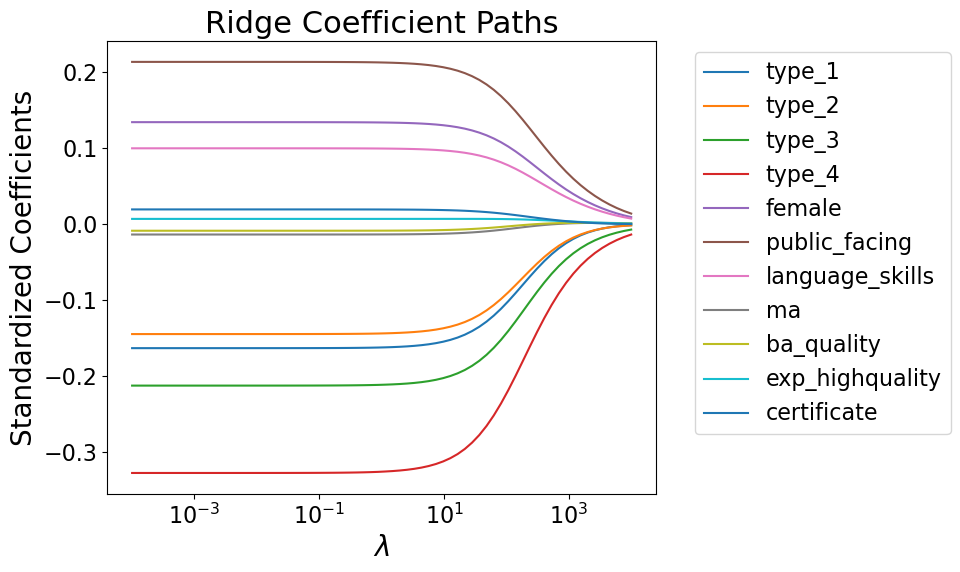

In [8]:
### ---- COEFFICIENT PATH PLOT FOR RIDGE ---- ###
#Standardize X 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Range of lambda values ---
lambdas = np.logspace(-4, 4, 70)  
coefficients = []

for lam in lambdas:
    model = LogisticRegression(
        penalty="l2",
        solver="liblinear",
        C=1/lam,           
        max_iter=1000
    )
    model.fit(X_scaled, y)
    coefficients.append(model.coef_[0])

coefficients = np.array(coefficients)

# --- Plot ---
plt.figure(figsize=(10,6))
for j in range(coefficients.shape[1]):
    plt.plot(lambdas, coefficients[:, j], label=f"{X.columns[j]}")

plt.xscale("log")
plt.xlabel("$\lambda$")
plt.ylabel("Standardized Coefficients")
plt.title("Ridge Coefficient Paths")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig("Ridge_coeff.png")   
plt.show()

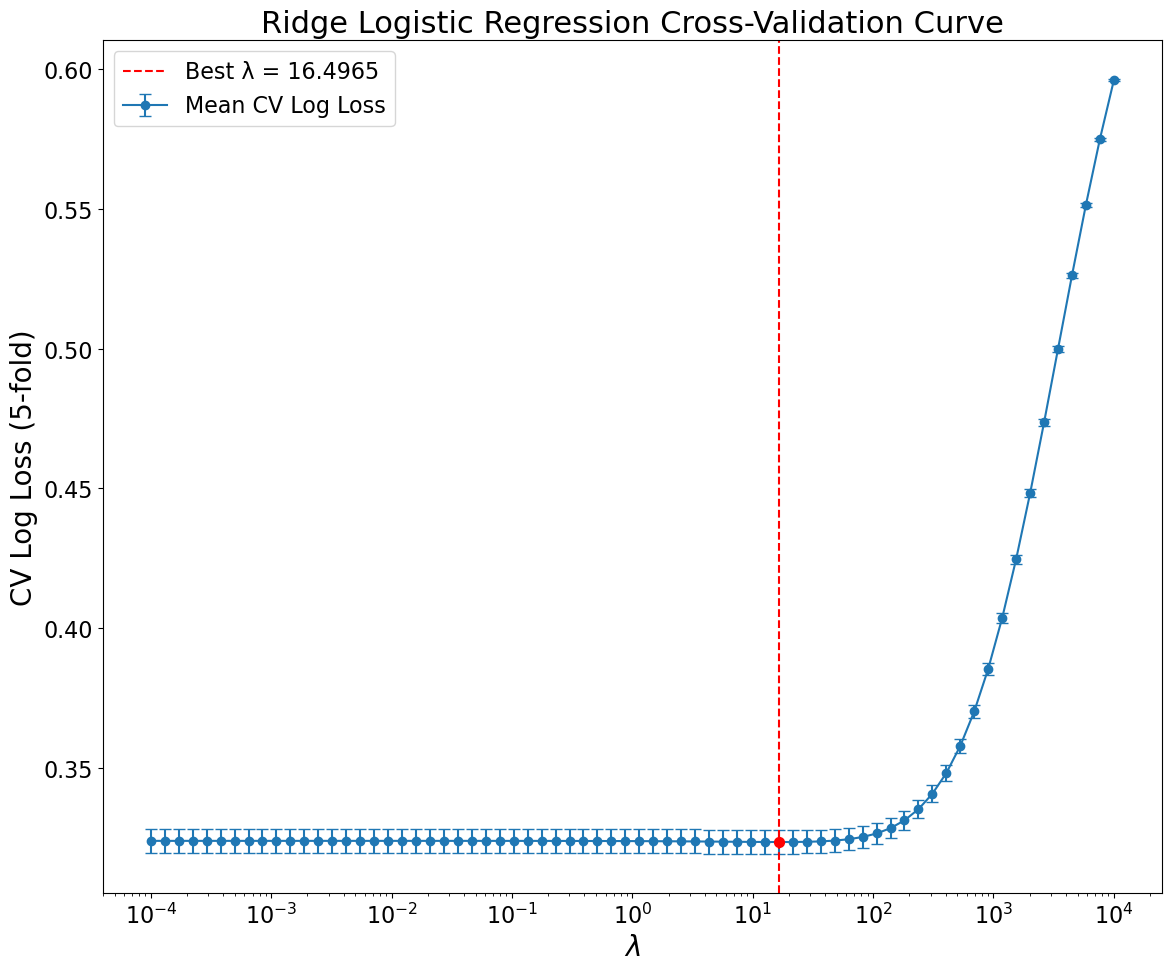

In [10]:
####---- CV LOGLOSS LAMBDA VALUES ----- ###
#Standardize X 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define lambda grid
lambdas = np.logspace(-4, 4, 70)

# 5-fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_means = []
cv_stds = []

for lam in lambdas:
    logloss_scores = []
    for train_idx, test_idx in kf.split(X_scaled):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = LogisticRegression(
            penalty="l2",
            solver="liblinear",
            C=1/lam,
            max_iter=1000
        )
        model.fit(X_train, y_train)

        # Predict probabilities
        y_pred_prob = model.predict_proba(X_test)[:, 1]
        logloss_scores.append(log_loss(y_test, y_pred_prob))

    cv_means.append(np.mean(logloss_scores))
    cv_stds.append(np.std(logloss_scores) / np.sqrt(kf.get_n_splits()))

cv_means = np.array(cv_means)
cv_stds = np.array(cv_stds)

# --- Find lambda that minimizes log loss ---
best_idx = np.argmin(cv_means)
best_lambda = lambdas[best_idx]
best_logloss = cv_means[best_idx]

# --- Plot ---
plt.rcParams.update({
    "font.size": 16,        
    "axes.labelsize": 20,  
    "axes.titlesize": 22,  
    "xtick.labelsize": 16,  
    "ytick.labelsize": 16,
    "legend.fontsize": 16,
})
plt.figure(figsize=(12,10))
plt.errorbar(lambdas, cv_means, yerr=cv_stds, fmt='-o', capsize=4, label="Mean CV Log Loss")
plt.axvline(best_lambda, color='red', linestyle='--', label=f"Best λ = {best_lambda:.4f}")
plt.scatter(best_lambda, best_logloss, color='red', s=50, zorder=5)

plt.xscale("log")
plt.xlabel("$\lambda$")
plt.ylabel("CV Log Loss (5-fold)")
plt.title("Ridge Logistic Regression Cross-Validation Curve")
plt.legend()
plt.tight_layout()
plt.savefig("ridge_cvlogloss.png", dpi=200)
plt.show()

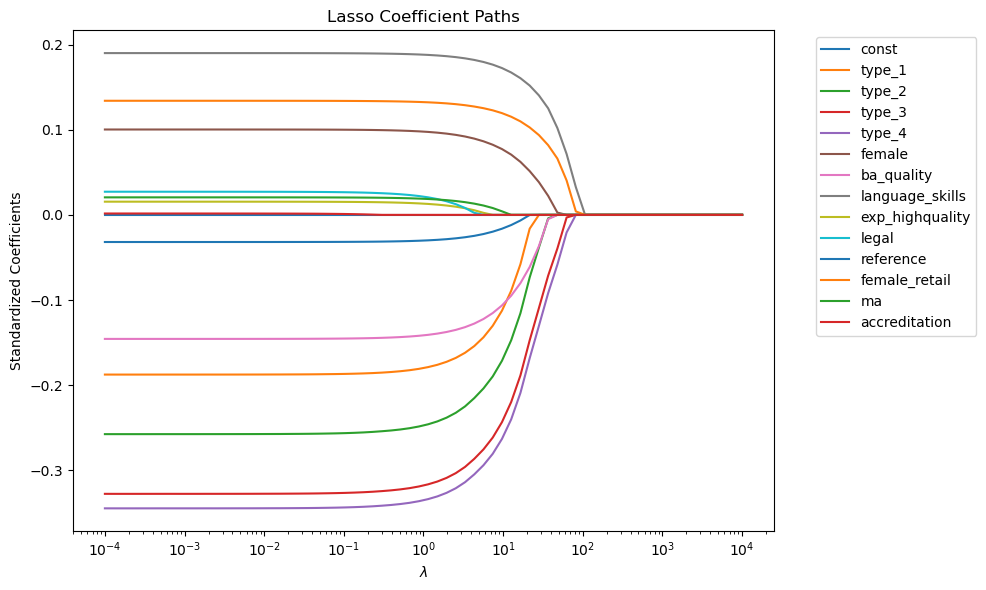

In [15]:
### ---- COEFFICIENT PATH PLOT FOR LASSO ---- ###
#Standardize X 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Range of lambda values ---
lambdas = np.logspace(-4, 4, 70)   
coefficients = []

for lam in lambdas:
    model = LogisticRegression(
        penalty="l1",
        solver="liblinear",
        C=1/lam,          
        max_iter=1000
    )
    model.fit(X_scaled, y)
    coefficients.append(model.coef_[0])

coefficients = np.array(coefficients)

# --- Plot ---
plt.figure(figsize=(10,6))
for j in range(coefficients.shape[1]):
    plt.plot(lambdas, coefficients[:, j], label=f"{X.columns[j]}")

plt.xscale("log")
plt.xlabel("$\lambda$")
plt.ylabel("Standardized Coefficients")
plt.title("Lasso Coefficient Paths")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig("Lasso_coeff.png")   
plt.show()

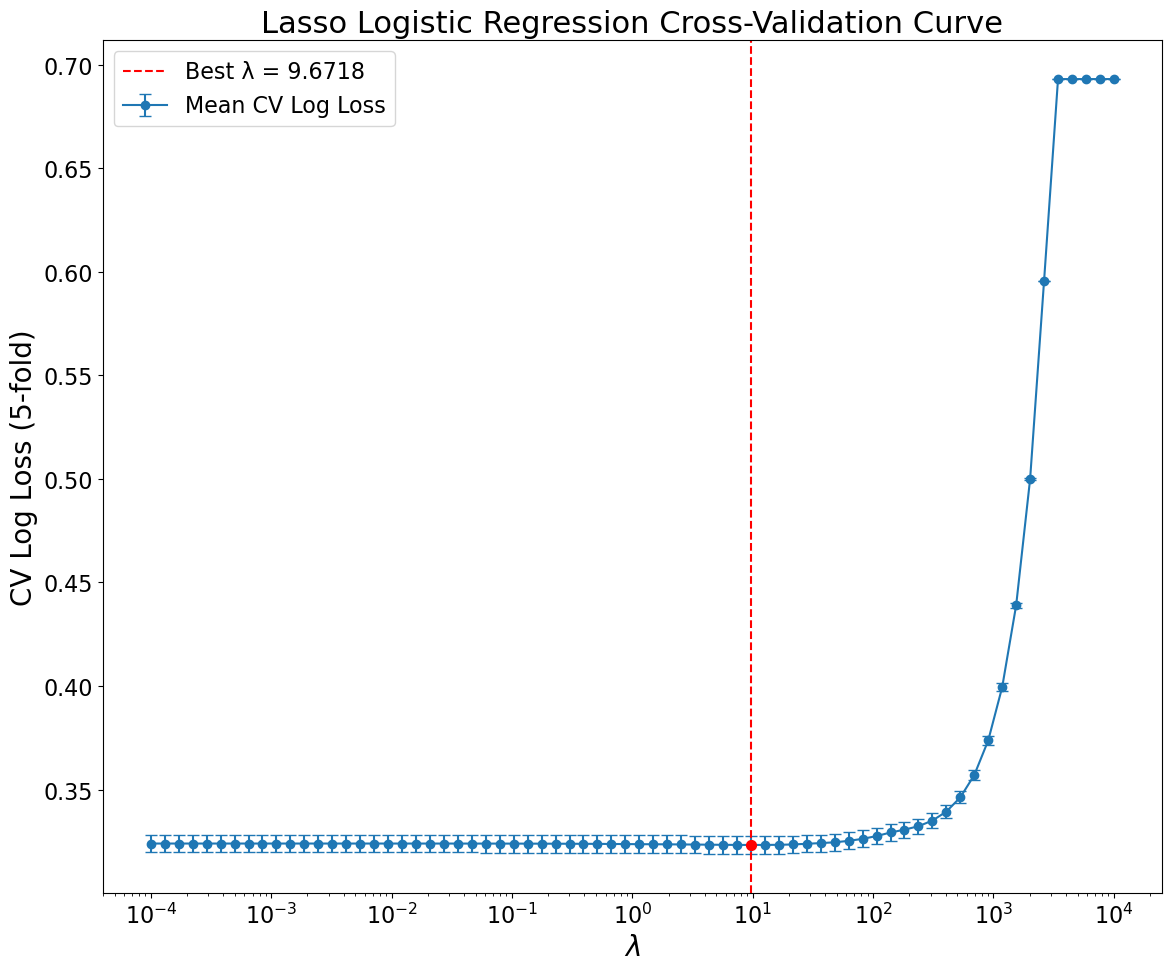

In [11]:
#### ---- CV MSE LAMBDA VALUES LASSO ---- ####

# --- Grid of lambda values ---
lambdas = np.logspace(-4, 4, 70)   

kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_means = []
cv_stds = []

for lam in lambdas:
    logloss_scores = []
    for train_idx, test_idx in kf.split(X_scaled):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]  

        model = LogisticRegression(
            penalty="l1",
            solver="liblinear",
            C=1/lam,
            max_iter=1000
        )
        model.fit(X_train, y_train)

        # Predict probabilities
        y_pred_prob = model.predict_proba(X_test)[:, 1]
        logloss_scores.append(log_loss(y_test, y_pred_prob))

    cv_means.append(np.mean(logloss_scores))
    cv_stds.append(np.std(logloss_scores) / np.sqrt(kf.get_n_splits()))

cv_means = np.array(cv_means)
cv_stds = np.array(cv_stds)

# --- Find lambda that minimizes log loss ---
best_idx = np.argmin(cv_means)
best_lambda = lambdas[best_idx]
best_logloss = cv_means[best_idx]

# --- Plot ---
plt.rcParams.update({
    "font.size": 16,      
    "axes.labelsize": 20,  
    "axes.titlesize": 22, 
    "xtick.labelsize": 16, 
    "ytick.labelsize": 16,
    "legend.fontsize": 16,
})
plt.figure(figsize=(12,10))
plt.errorbar(lambdas, cv_means, yerr=cv_stds, fmt='-o', capsize=4, label="Mean CV Log Loss")
plt.axvline(best_lambda, color='red', linestyle='--', label=f"Best λ = {best_lambda:.4f}")
plt.scatter(best_lambda, best_logloss, color='red', s=50, zorder=5)

plt.xscale("log")
plt.xlabel("$\lambda$")
plt.ylabel("CV Log Loss (5-fold)")
plt.title("Lasso Logistic Regression Cross-Validation Curve")
plt.legend()
plt.tight_layout()
plt.savefig("lasso_cvlogloss.png", dpi=200)
plt.show()